In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 불러오기
df = pd.read_csv('NVspinData_None_-1_230807.csv')

# 데이터셋 분리: train_set 8 : test_set 2
train_df, test_df = train_test_split(df, shuffle=True, test_size=0.2)
# train_set을 다시 8:2로 나눠서 train_set과 validation_set을 만듦
train_df, val_df = train_test_split(train_df, shuffle=True, test_size=0.2)
# random_state=42

# 모든 시퀀스의 길이 중에서 최대 길이를 구하기
all_sequences = [eval(seq) for seq in df['combination'].values]
max_seq_length = max([len(seq) for seq in all_sequences])

# 각 데이터셋에서 theta, phi, sequence 추출하고 reshape 적용
theta_train = train_df['Theta'].values.reshape(-1, 1)
phi_train = train_df['Phi'].values.reshape(-1, 1)
sequence_train = pad_sequences(train_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_val = val_df['Theta'].values.reshape(-1, 1)
phi_val = val_df['Phi'].values.reshape(-1, 1)
sequence_val = pad_sequences(val_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_test = test_df['Theta'].values.reshape(-1, 1)
phi_test = test_df['Phi'].values.reshape(-1, 1)
sequence_test = pad_sequences(test_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

# theta_train[:5]

array([[1.67823594],
       [1.02865399],
       [1.28304092],
       [2.85908995],
       [2.77122722]])

In [31]:

# 모델 정의
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')

# theta와 phi를 Concatenate
merged = Concatenate()([theta_input, phi_input])

# 시퀀스를 예측하기 위한 SimpleRNN 레이어
repeated_vector = RepeatVector(max_seq_length)(merged)  # max_sequence_length는 시퀀스의 최대 길이

rnn_layer = SimpleRNN(64, return_sequences=True, name='rnn_layer')(repeated_vector)

output = TimeDistributed(Dense(5, activation='softmax'), name='output_layer')(rnn_layer)

model = Model(inputs=[theta_input, phi_input], outputs=output)

# 컴파일 및 훈련
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit([theta_train, phi_train], np.expand_dims(sequence_train, -1), 
                    validation_data=([theta_val, phi_val], np.expand_dims(sequence_val, -1)), epochs=50, batch_size=64)

# 검증
loss, accuracy = model.evaluate([theta_test, phi_test], np.expand_dims(sequence_test, -1))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/50
124/124 [==============================] - 2s 9ms/step - loss: 1.1646 - accuracy: 0.5107 - val_loss: 0.9028 - val_accuracy: 0.5932
Epoch 2/50
124/124 [==============================] - 1s 6ms/step - loss: 0.8647 - accuracy: 0.6000 - val_loss: 0.8443 - val_accuracy: 0.6012
Epoch 3/50
124/124 [==============================] - 1s 7ms/step - loss: 0.8372 - accuracy: 0.6045 - val_loss: 0.8350 - val_accuracy: 0.6038
Epoch 4/50
124/124 [==============================] - 1s 6ms/step - loss: 0.8214 - accuracy: 0.6113 - val_loss: 0.8314 - val_accuracy: 0.6175
Epoch 5/50
124/124 [==============================] - 1s 6ms/step - loss: 0.7078 - accuracy: 0.7022 - val_loss: 0.4857 - val_accuracy: 0.8265
Epoch 6/50
124/124 [==============================] - 1s 6ms/step - loss: 0.4401 - accuracy: 0.8456 - val_loss: 0.4020 - val_accuracy: 0.8592
Epoch 7/50
124/124 [==============================] - 1s 6ms/step - loss: 0.4035 - accuracy: 0.8605 - val_loss: 0.4200 - val_accuracy: 0.8493
Epoch 

In [67]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과 출력
for i in range(10):
    print(f"Sample {i + 1}:")
    print("Theta    :", theta_samples[i])
    print("Phi      :", phi_samples[i])
    print("Actual   :", sequence_samples[i])
    print("Predicted:", predicted_sequences[i])
    print("----------")


1/1 [==============================] - 0s 27ms/step
Sample 1:
Theta    : [0.71090601]
Phi      : [4.57566559]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 4 4 1 1 3 1 0 0 4]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 4 4 1 1 1 3 2 0 0]
----------
Sample 2:
Theta    : [1.5364912]
Phi      : [3.84077424]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 2 2 0]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 3 0]
----------
Sample 3:
Theta    : [2.41592325]
Phi      : [2.22908683]
Actual   : [0 0 0 0 0 0 0 0 0 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3]
Predicted: [0 0 0 0 0 0 0 0 0 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3]
----------
Sample 4:
Theta    : [3.00294276]
Phi      : [4.37157918]
Actual   : [0 0 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 3 3]
Predicted: [0 0 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 1 3 3]
----------
Sample 5:

In [30]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame({
    'Theta': theta_samples,
    'Phi': phi_samples,
    'Actual Sequence': [list(seq) for seq in sequence_samples],
    'Predicted Sequence': [list(seq) for seq in predicted_sequences]
})

# 결과를 CSV 파일로 저장
df_results.to_csv('rnn_results2.csv', index=False)

print("Results saved to rnn_results.csv")


1/1 [==============================] - 0s 21ms/step
Results saved to rnn_results.csv


In [41]:
print(type(theta_train), theta_train.shape)
print(type(phi_train), phi_train.shape)
print(type(sequence_train), len(sequence_train))
print(type(theta_val), theta_val.shape)
print(type(phi_val), phi_val.shape)
print(type(sequence_val), len(sequence_val))

<class 'numpy.ndarray'> (7904, 1)
<class 'numpy.ndarray'> (7904, 1)
<class 'numpy.ndarray'> 7904
<class 'numpy.ndarray'> (1976, 1)
<class 'numpy.ndarray'> (1976, 1)
<class 'numpy.ndarray'> 1976


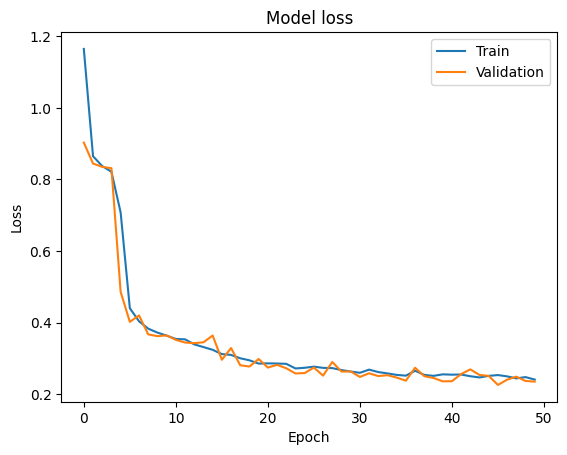

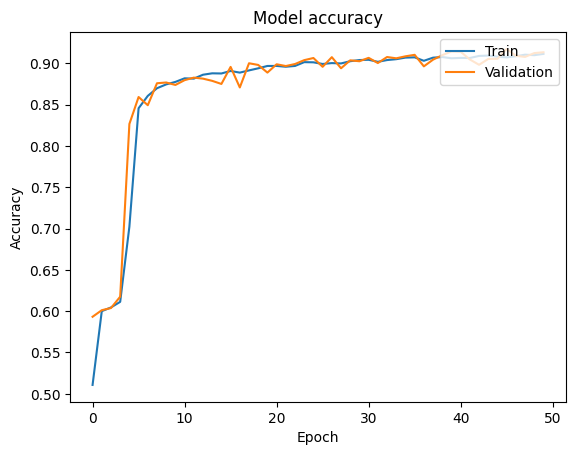

 1/78 [..............................] - ETA: 13s - loss: 0.2592 - accuracy: 0.9152

c:\Python310\lib\site-packages\keras\src\engine\functional.py:639: UserWarning: Input dict contained keys ['sequence_input'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


78/78 [==============================] - 0s 3ms/step - loss: 0.2405 - accuracy: 0.9127
Test Accuracy: 91.27
Test Loss: 24.05


In [42]:
import matplotlib.pyplot as plt

def plot_history(history):
         # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        # plt.axis([45, 70, 0, 0.01])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        # plt.axis([45, 60, 0.999, 1.0])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

def evaluate(model, theta, phi, sequence):
    loss, acc = model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
    print("Test Accuracy: {:.2f}".format(acc*100))
    print("Test Loss: {:.2f}".format(loss*100))

# 결과 그래프 그리기
plot_history(history)

# 모델 성능 평가
evaluate(model, theta_test, phi_test, sequence_test)

In [63]:
# 새로운 theta와 phi 값 정의
new_theta = np.array([np.pi/2]).reshape(-1, 1)  # 예시 값
new_phi = np.array([np.pi]).reshape(-1, 1)    # 예시 값

# 모델로 예측
predicted_sequence = model.predict([new_theta, new_phi])

# 결과 출력 (예측값은 확률 분포로 나올 것이므로 가장 높은 확률을 가진 인덱스를 선택)
predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)
print(predicted_sequence_indices[0])

1/1 [==============================] - 0s 19ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2]
